<a href="https://colab.research.google.com/github/Manvi1203/MLnow_GirlScript/blob/main/SMS_Spam_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing the datset

In [3]:
#Importing important libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
#Importing dataset from the link:https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection
messages = pd.read_table('/content/SMSSpamCollection', sep='\t', header=None,names=['label', 'message'])
#No of rows and columns
messages.shape
#Prints 10 initial values
messages.head(10)

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


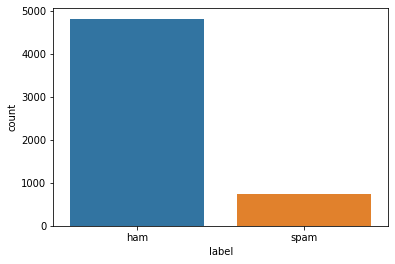

In [5]:
sns.countplot(messages['label'])

In [6]:
# Percentage of data points with ham label 
print(messages[messages['label']=='spam'].shape[0]*100/messages.shape[0])

13.408723747980615


In [7]:
#Check for missing values
messages.isna().sum()
#If there are missing values we can either drop the row or filling na values using the Embarked feature with the most frequent value
#df.Embarked = df.Embarked.fillna(value='')

label      0
message    0
dtype: int64

#Exploratory Data Analysis

In [8]:
messages.describe()

,label,message
count,5571,5571
unique,2,5168
top,ham,"Sorry, I'll call later"
freq,4824,30


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


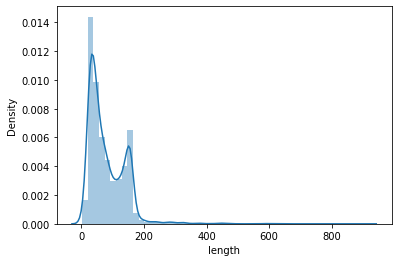

In [9]:
#Distribution based on length of words
messages['length']=messages['message'].apply(lambda x: len(x))
sns.distplot(messages['length'], kde=True) #kde is bool type, whether to plot gaussian kernel desity estimate, rug- bool type, whether to plot rug plot- vertical istribution

In [10]:
dt=messages.groupby('label').mean()
dt

,length
label,
ham,71.488806
spam,138.670683


In [11]:
from wordcloud import WordCloud, STOPWORDS

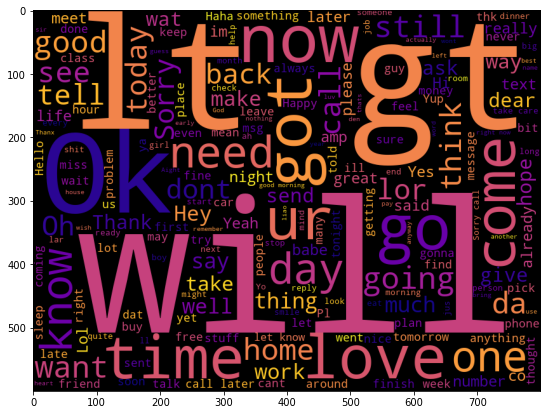

In [12]:
#Word Cloud of the text data represents text data in which the size of each word indicates its frequency
def show_wordcloud(df):
  text=' '.join(df['message'].astype(str).tolist()) #casts messages to string type and then converts to a list
  stopwords= set(STOPWORDS) #Stopwords is a set of commonly used words like a, the, is, are
  diag= WordCloud(stopwords=stopwords, background_color='black', colormap='plasma', width=800, height=600).generate(text) #by passing the parameter stopwords we can remove the words that we dont want to show

  plt.figure(figsize=(10,7), frameon=True)
  plt.imshow(diag)
  plt.show()

ham=messages[messages['label']=='ham'].copy()
show_wordcloud(ham)


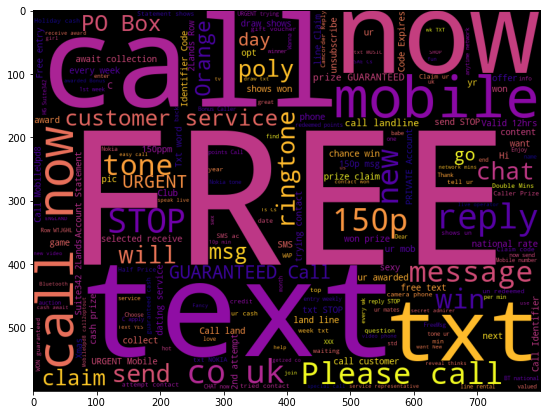

In [13]:
spam=messages[messages['label']=='spam'].copy()
show_wordcloud(spam)

In [14]:
import string
def word_count_plot(x):
    a = [i for i in x if i not in string.punctuation] #string.punctuation in python gives the set of all punctuation marks
    a = "".join(a).split() #.split() in python splits the string into a list of words
    b = [word.lower() for word in a if word.lower() not in STOPWORDS]  #lower all the words except those in stopwords set
    return b

In [15]:
# word_count_plot function is passed through all the messages in ham and spam 
ham['message'] = ham['message'].apply(word_count_plot)
words_ham = ham['message'].tolist()
spam['message'] = spam['message'].apply(word_count_plot)
words_spam = spam['message'].tolist()

In [16]:
ham.head(10)

,label,message,length
0,ham,"[go, jurong, point, crazy, available, bugis, n...",111
1,ham,"[ok, lar, joking, wif, u, oni]",29
3,ham,"[u, dun, say, early, hor, u, c, already, say]",49
4,ham,"[nah, dont, think, goes, usf, lives, around, t...",61
6,ham,"[even, brother, speak, treat, aids, patent]",77
7,ham,"[per, request, melle, melle, oru, minnaminungi...",160
10,ham,"[im, gonna, home, soon, dont, want, talk, stuf...",109
13,ham,"[ive, searching, right, words, thank, breather...",196
14,ham,"[date, sunday, will]",35
16,ham,"[oh, kim, watching]",26


#Data Cleaning and Preprocessing


In [17]:
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer 

In [19]:
#Stemming is the process of producing morphological variants of a root/base word. A stemming algorithm reduces the words “chocolates”, “chocolatey”, “choco” to the root word, “chocolate”
#Porter stemmer helps us stem text data used.
ps= PorterStemmer()
def preprocess(x):
  x=x.lower()
  x=re.sub(r'[^0-9a-zA-Z]', ' ',x) #Replace all characters except 0-9,a-z,A-Z with space
  x=re.sub(r'\s+', ' ', x) #Eliminate duplicate whitespaces
  l= [item for item in x if item not in string.punctuation]
  processed= [ps.stem(i) for i in l if i not in stopwords.words('english')]
  return processed


In [21]:
#Train-Test Splitting of Data
#It is used for evaluating the performance of a machine learning algorithm 
X=messages['message']
y=messages['label']
X_train, X_test ,y_train, y_test= train_test_split(X,y,test_size=0.2)


#Pipeline

Bag of Words- by using bag of words we convert a text into its equivalent vectors of numbers. It involves three sub-processes:

1. Tokenization-tokenizing strings and giving an integer id for each possible token by using white-spaces and punctuation as token separators.

2. Vectorization-counting the occurrences of tokens in each document.

3. TF-IDF- normalizing and weighting with diminishing importance tokens that occur in the majority of documents.

* True Positives(TP)- A message that is actually spam and is classified as spam

* True Negatives(TN)- A message that is not spam and is classifies as not spam(ham)

* False Positives(FP)- A message that is not spam but is classified as spam

* False Negatives(FN)- A message that is spam but classified as not spam or ham

Accuracy- (TN+TP)/(TP+TN+FP+FN) -**Confusion matrix** which is required to compute the accuracy of the machine learning algorithm in classifying the data into its corresponding labels.

Precision-positive predictive value- TP/(TP+FP)

Recall- true positive value- TP/(TP+FN)

F1 Score- considers both precision and recall- 2(Precision*Recall)/(Precision+Recall)

In [22]:
#X is sms text and Y is label
#Count Vectrizer-counts the number of times a token shows up in the document and uses this value as its weigh
def model(model_name,X_train,y_train,X_test,y_test):
    pipeline=Pipeline([
    ('bow', CountVectorizer(analyzer=preprocess)),
    ('tfidf', TfidfTransformer()),
    ('model', model_name),
    ])
    pipeline.fit(X_train,y_train)

    preds=pipeline.predict(X_test)

    print (classification_report(y_test,preds))
    print (confusion_matrix(y_test,preds))
    print('Accuracy:', pipeline.score(X_test, y_test)*100)
    print("Training Score:",pipeline.score(X_train,y_train)*100)
    from sklearn.metrics import accuracy_score
    score = accuracy_score(y_test,preds)
    return score


#Naive Bayes Classifier




In [25]:
mnb=model(MultinomialNB(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.96      1.00      0.98       967
        spam       0.99      0.74      0.84       148

    accuracy                           0.96      1115
   macro avg       0.98      0.87      0.91      1115
weighted avg       0.97      0.96      0.96      1115

[[966   1]
 [ 39 109]]
Accuracy: 96.41255605381166
Training Score: 96.27468581687613


#Random Forest Classifier

In [26]:
rf=model(RandomForestClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       0.98      0.86      0.92       148

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[964   3]
 [ 20 128]]
Accuracy: 97.9372197309417
Training Score: 99.97755834829444


#Gradient Boosting

In [27]:
gb=model(GradientBoostingClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       0.97      0.87      0.92       148

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[963   4]
 [ 19 129]]
Accuracy: 97.9372197309417
Training Score: 99.19210053859963


#XGBoost

In [28]:
xgb=model(XGBClassifier(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       967
        spam       0.98      0.86      0.92       148

    accuracy                           0.98      1115
   macro avg       0.98      0.93      0.95      1115
weighted avg       0.98      0.98      0.98      1115

[[964   3]
 [ 20 128]]
Accuracy: 97.9372197309417
Training Score: 99.03500897666068


#Support Vector Machines(SVM) Classifier






In [29]:
svc=model(SVC(),X_train,y_train,X_test,y_test)

              precision    recall  f1-score   support

         ham       0.97      1.00      0.98       967
        spam       0.99      0.79      0.88       148

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

[[966   1]
 [ 31 117]]
Accuracy: 97.13004484304932
Training Score: 97.93536804308796


#Comparing the models

,Model,Accuracy_score
1,RF,0.979372
2,GBoost,0.979372
3,XGBoost,0.979372
4,SVC,0.971300
0,MNB,0.964126


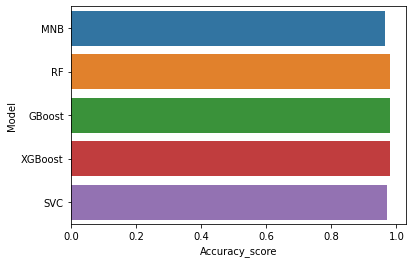

In [30]:
models = pd.DataFrame({
    'Model':['MNB','RF', 'GBoost', 'XGBoost', 'SVC'],
    'Accuracy_score' :[mnb ,rf, gb, xgb, svc]
})
sns.barplot(x='Accuracy_score', y='Model', data=models)
models.sort_values(by='Accuracy_score', ascending=False)